# Optimal representation of vector fields

Generate raw data given vector of orientations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image_resolution = [32,32]

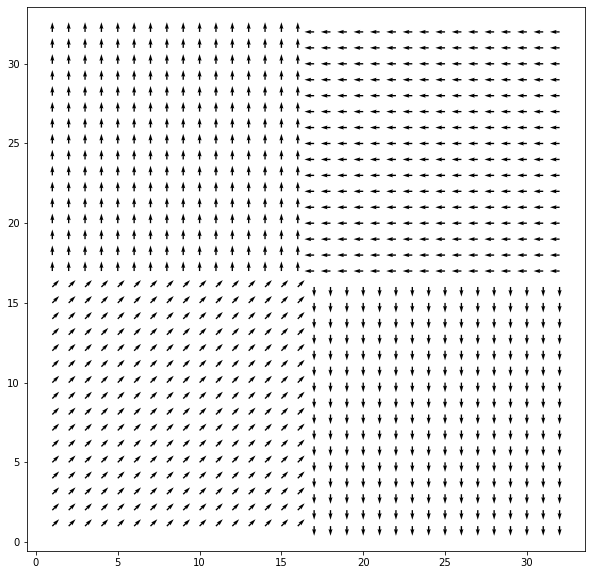

In [2]:
def gen(v, noise = 0):
    "Use an array of 4 orientations as input (0..360)."
    "We can add some noise to the output if required."
    v = np.array(v)
    v = (v.astype(float))/180*np.pi
    d = [image_resolution[0],image_resolution[1],2]
    xs = np.linspace(1,d[0],d[0])
    ys = np.linspace(1,d[1],d[1])
    xm,ym = np.meshgrid(xs, ys)
    img = np.zeros(d)
    sp = [int(d[0]/2),int(d[1]/2)]
    square = np.zeros([sp[0],sp[1],2])
    square[:,:,0] = np.cos(v[0])
    square[:,:,1] = np.sin(v[0])
    if noise > 0:
        square = square + np.random.normal(0,noise,square.shape)

    img[0:sp[0],0:sp[1],0] = square[:,:,0]
    img[0:sp[0],0:sp[1],1] = square[:,:,1]

    square[:,:,0] = np.cos(v[1])
    square[:,:,1] = np.sin(v[1])
    if noise > 0:
        square = square + np.random.normal(0,noise,square.shape)

    img[sp[0]:d[0],0:sp[1],0] = square[:,:,0]
    img[sp[0]:d[0],0:sp[1],1] = square[:,:,1]

    square[:,:,0] = np.cos(v[2])
    square[:,:,1] = np.sin(v[2])
    if noise > 0:
        square = square + np.random.normal(0,noise,square.shape)

    img[sp[0]:d[0],sp[1]:d[1],0] = square[:,:,0]
    img[sp[0]:d[0],sp[1]:d[1],1] = square[:,:,1]

    square[:,:,0] = np.cos(v[3])
    square[:,:,1] = np.sin(v[3])
    if noise > 0:
        square = square + np.random.normal(0,noise,square.shape)

    img[0:sp[0],sp[1]:d[1],0] = square[:,:,0]
    img[0:sp[0],sp[1]:d[1],1] = square[:,:,1]

    return img

def angle(img):
    "Return the angle in -3.1415 to 3.1415"
    return np.arctan2(img[:,:,1], img[:,:,0])

def disp(img):
    "Display something coming back from gen()"
    d = img.shape
    xs = np.linspace(1,d[0],d[0])
    ys = np.linspace(1,d[1],d[1])
    fig, ax = plt.subplots(figsize=(10, 10))
    Q = ax.quiver(xs, ys, img[:,:,0], img[:,:,1], units='width')

def saveTensor(erg, filename):
    "Save a tensor to a file"
    img_np = erg.numpy()
    mi = np.min(img_np)
    ma =  np.max(img_np)
    img_np = (img_np.reshape((32*16,32*16,3)) - mi)/(ma-mi)*255
    img_np = img_np.astype(np.uint8)    
    im = Image.fromarray(img_np)
    im.save(filename)

# test
img = gen([45, 90, 180, 270])
disp(img)


In [3]:
img = angle(gen([45, 90, 180, 270]))/3.1415927
print(np.mean(img), np.std(img), np.min(img), np.max(img))
print(360*np.random.rand(4,1))

0.31249999538349155 0.5412658693692468 -0.49999999261358635 0.9999999852271726
[[256.62867914]
 [ 71.1593204 ]
 [ 45.58268864]
 [335.07785508]]


## Network A
We need to get a 32,32,1 input into a 32,32 image, a visualization of the vector field encoding orientation as atan2(y,x).

In [4]:
# a data generator Using the above functions for matching pairs of input and output
def datagenerator(batchsize, mode="train"):
    "Generate a batch of data"
    noise = 0.1 # applied as std on radiants (-3.14...3.14)
    while True:
        batch_x = []
        batch_y = []
        for i in range(batchsize): 
            # load your images from numpy arrays or read from directory
            # create a random orientation
            img = angle(gen(360*np.random.rand(4,1),noise=noise)) # should return 32,32,1
            lab = np.zeros((32*16,32*16, 1))  # this should be the output size ... gen(labels[start+i])
            batch_x.append(img) # should we normalize this input?
            batch_y.append(lab)

        yield np.array(batch_x), np.array(batch_y)

#(a, b) = datagenerator(1, mode="train")


In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import tensorflow as tf

def stable_detection_loss(forward_model, mask):
    "A loss function that can use the model itself for prediction on sets of images."
    "Mask is a tensor that contains 0, 1, 2, or 3 for each pixel in the output image as a quadrant."
    alpha = 0.5 # just to make this code work for now
    def loss(y_true, y_pred):
        # We can ignore y_true and just work with y_pred (first dimension is batch size we need a batch size of 1)
        # How many iterations do we want to do here to average a loss?
        n_iter = 1
        losses = None
        for i in range(n_iter):
            # Get a random image
            orientations = 360*np.random.rand(4,1)
            imgA = angle(gen(orientations))
            # change one orientation and get another image
            fixOrientationQuadrant = np.random.randint(0,4,1)
            orientations[fixOrientationQuadrant] = 360*np.random.rand(1,1)
            imgB = angle(gen(orientations))

            # start a new keras session and clean up?

            forward_model.trainable = False
            predA = forward_model(imgA.reshape((1,32,32,1)), training = False)
            predB = forward_model(imgB.reshape((1,32,32,1)), training = False)
            forward_model.trainable = True
            # lets store the predA as an image - does not work because we only get a symbolic tensor back in predA and we cannot do .numpy()
            # saveTensor(predA, f'predA.png')
            #for i, image in enumerate(predA, 1):
            #    tf.keras.preprocessing.image.save_img(f'predA_{i}.png', image)
            # tf.keras.preprocessing.image.save_img('predA.png',predA[0])

            del imgA
            del imgB
            # compute the loss for this pair of imgA and imgB
            # we should use the mask now to compute a combined loss for the 
            # regions that should be the same and the regions that should be different

            # three quadrants should have the same orientations
            same = layers.Lambda(lambda x: K.switch(K.not_equal(x[0], fixOrientationQuadrant),x[1]-x[2],0.0))([mask, predA, predB])
            
            # one quadrant should have a different orientation
            diff = layers.Lambda(lambda x: K.switch(K.equal(x[0],fixOrientationQuadrant),x[1]-x[2],0.0))([mask, predA, predB])

            # we want to maximize the difference in the one quadrant
            #diffMax = layers.Lambda(lambda x: K.switch(K.less_equal(x, 1e-6), tf.zeros_like(x), K.sigmoid(tf.ones_like(x)/x)))(diff)

            # we would like to minimize same and maximize diff (should I use 1-K.sigmoid(x[0]) to make sure its 1 at most?)
            dd = layers.Lambda(lambda x: (1-K.sigmoid(x[0])) + x[1])([diff, same])
            # print(K.mean(K.square(predA - predB)))
            if i == 0:
                #losses = K.mean(K.square(predA - predB))
                losses = K.mean(K.square(dd))
            else:
                #losses += K.mean(K.square(predA - predB))
                losses += K.mean(K.square(dd))

            # we need to add some more loss for the generated images - means should be 0 and std should be 0.17 - similar to input
            #losses += K.mean(K.square(- K.mean(predA)))
            # add std loss
            # but compute an average loss over all patches in the output
            # there is tf.image.extract_patches() which can do this, we need to compute 16x16 patches with a stride of 16, stack
            # them and compute the std and the mean of those. or min?
            # This would create a measure of local contrast 
            losses += K.mean(K.square( (tf.ones_like(predA)*0.17) - K.std(predA)))

            # a better loss would be a perceptual loss function using VGG19 for example
            # that way we could judge the two images in a 'humanized' feature space
            # as an example we could
            # def build_vgg(hr_shape):
            #    vgg = VGG19(weights='imagenet', include_top=False, input_shape=hr_shape)
            #    return Model(inputs = vgg.inputs, outputs=vgg.layers[10].output)
            # vgg = build_vgg((1,512,512,1))
            # vgg.trainable = False
            # to compare the features for predA and predB in feature space we can use mean squared error as a loss function
            #losses += K.mean(K.square(vgg(predA) - vgg(predB)))

            del predA
            del predB
        return losses/n_iter
    return loss

def res_block(ip):
    res_model = layers.Conv2D(64, (3,3), padding = 'same')(ip)
    res_model = layers.BatchNormalization(momentum = 0.5)(res_model)
    res_model = layers.PReLU(shared_axes = [1,2])(res_model)

    res_model = layers.Conv2D(64, (3,3), padding = 'same')(res_model)
    res_model = layers.BatchNormalization(momentum = 0.5)(res_model)

    return layers.add([ip, res_model])

def upscale_block(ip):
    up_model = layers.Conv2D(64, (3,3), padding = 'same')(ip)
    up_model = layers.UpSampling2D( size = 2)(up_model)
    up_model = layers.PReLU(shared_axes = [1,2])(up_model)

    return up_model

num_res_block = 4 # instead of 16
gen_ip = keras.Input(shape = (32, 32, 1), name = 'gen_ip')

# we can upsample first before we do resnet - looks similar to just increasing the size of the input image... 
gen_ip2 = upscale_block(gen_ip)
gen_ip3 = upscale_block(gen_ip2)

layer = layers.Conv2D(64, (9,9), padding='same')(gen_ip3)
layer = layers.PReLU(shared_axes = [1,2])(layer)

temp = layer

for i in range(num_res_block):
    layer = res_block(layer)

layer = layers.Conv2D(64, (3,3), padding = 'same')(layer)
layer = layers.BatchNormalization(momentum = 0.5)(layer)
layer = layers.add([layer, temp])
layer = upscale_block(layer)
layer = upscale_block(layer)
# layer = upscale_block(layer)

# 3D means color picture here, we should probably use a smaller kernel size at this output layer
op = layers.Conv2D(3, (3,3), padding = 'same')(layer)

model = keras.Model(inputs=gen_ip, outputs=op)

# plot the model
# keras.utils.plot_model(model, "model.png", show_shapes=True)

# get a mask for the output that is 0 everywhere but 0,1,2,3 in the quadrants we changed
mask = np.zeros((32*16,32*16,1))
sp = [int(32*16/2),int(32*16/2)]
d = [32*16,32*16]
mask[0:sp[0],0:sp[1],0] = 0
mask[sp[0]:d[0],0:sp[1],0] = 1
mask[sp[0]:d[0],sp[1]:d[1],0] = 2
mask[0:sp[0],sp[1]:d[1],0] = 3
# that mask needs to be a Tensor (disconnected layer hopefully)
maskT = K.constant(mask)

model.compile(loss=stable_detection_loss(forward_model=model, mask=maskT), optimizer='adam')

batch = 1
#K.set_value(model.optimizer.learning_rate, 1e-5)
model.fit(datagenerator(batch, "train"), steps_per_epoch = 200, epochs=50)

model.save("model.h5")
del model


2022-07-20 15:37:30.893037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
100/100 [==============================] - 749s 7s/step - loss: 0.2641
Epoch 2/10
100/100 [==============================] - 783s 8s/step - loss: 0.2166
Epoch 3/10
100/100 [==============================] - 752s 8s/step - loss: 0.2133
Epoch 4/10
100/100 [==============================] - 733s 7s/step - loss: 0.2139
Epoch 5/10
100/100 [==============================] - 764s 8s/step - loss: 0.2083
Epoch 6/10
100/100 [==============================] - 786s 8s/step - loss: 0.2062
Epoch 7/10
100/100 [==============================] - 796s 8s/step - loss: 0.2054
Epoch 8/10
100/100 [==============================] - 793s 8s/step - loss: 0.2037
Epoch 9/10
100/100 [==============================] - 2498s 25s/step - loss: 0.2029
Epoch 10/10
100/100 [==============================] - 721s 7s/step - loss: 0.2032


/usr/local/anaconda3/envs/optimal-representation/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


An impossible situation for a model is one where it would need to know beforehand what the next input it receives looks like. It will get a second input very similar to the first one but one quadrant of the input will have a different value. Its goal is now to create a display that will be the same in regions that remain the same and dissimilar in the quadrant that will change in the future.

In [6]:
# Recreate the exact same model purely from the file (does this work because our loss needs the model?)
model = keras.models.load_model("model.h5", custom_objects={'loss': stable_detection_loss(forward_model=None, mask = None)}, compile=False)


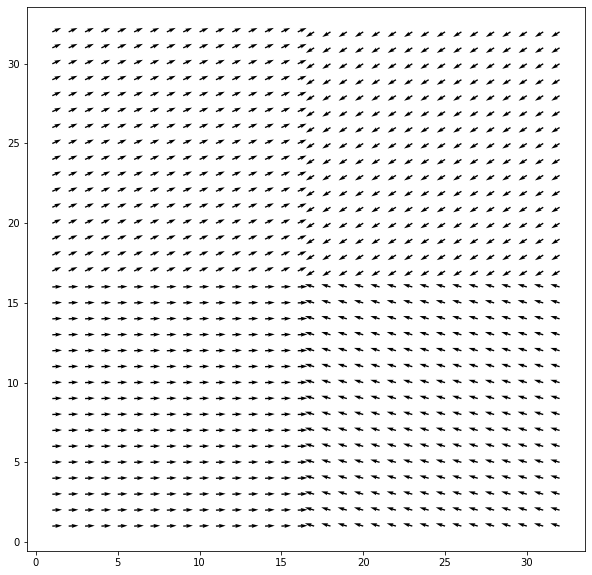

In [19]:
orientations = np.random.rand(4,1)*360
img = gen(orientations,0)
disp(img)
img2 = angle(img)
erg = model(img2.reshape((1,32,32,1)), training = False)


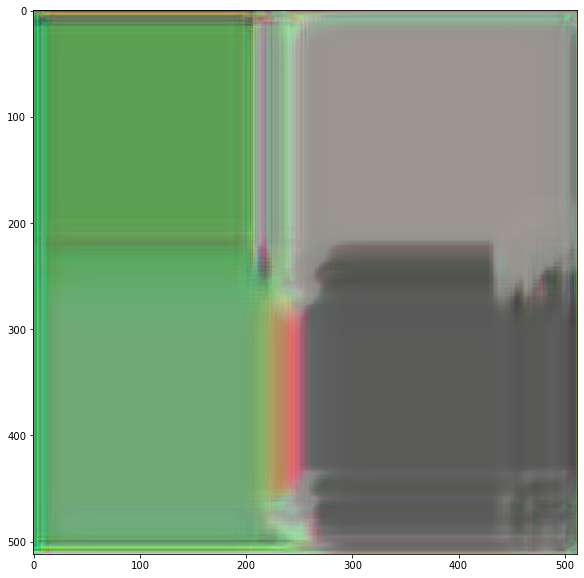

In [20]:
import matplotlib.pyplot as plt
img_np = erg.numpy()
mi = np.min(img_np)
ma =  np.max(img_np)
figure = plt.figure(figsize=(10,10))
plt.imshow( (img_np.reshape((32*16,32*16,3)) - mi)/(ma-mi)*1 , cmap=plt.get_cmap('gray'))